# Description of the first homework assignment  

Consider a picture representing a white sheet of A4 paper with some handwritten numbers in a dark color (they have different sizes, but they are all oriented in the same direction, which is aligned with one of the edges of the paper).  Consider the attached pictures as examples. Some are easy, others are harder. Note that the paper might be pictured at an angle or from a slanted perspective.  In all pictures the four edges of the paper are clearly visible, but might be incomplete.

Write a notebook that, given a directory, will process all images in that directory and extract all digits it can find from each picture. For each file, it should then print:
- the name of the file, followed by  
- each of the digits that has been identified on that sheet of paper, from top to bottom.

### Examples
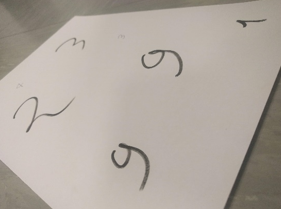 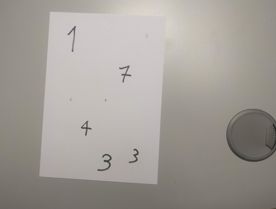 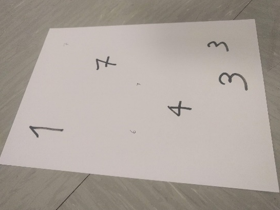 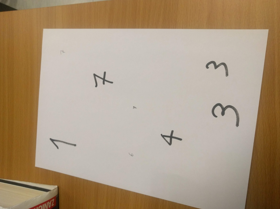

## Imports

In [1]:
import skimage
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import ipywidgets as widgets
import itertools

from typing import Self

### Helper class: Image Collection 

In [2]:
class ImageItem:
    def __init__(self, path: pathlib.Path):
        self.path = path
    
    def load(self):
        return self.__load(self.path)
    
    def load_grayscale(self):
        return skimage.color.rgb2gray(self.__load(self.path))        
    
    @staticmethod
    def __load(path: pathlib.Path):
        return skimage.io.imread(path)


class ImageCollection:
    def __init__(self, dir_path: pathlib.Path | str | None = None):
        self.__entries: list[ImageItem] = self.__scan_dir(dir_path) if dir_path else []
    
    def __len__(self) -> int:
        return len(self.__entries)

    def __getitem__(self, key: slice | str | int) -> Self | pathlib.Path:
        if isinstance(key, slice):
            return ImageCollection().__add_entries(self.__entries[key])
        
        if isinstance(key, str):
            return self.__get_item_by_name(key)
        
        if isinstance(key, int):
            return self.__entries[key]
        
        raise TypeError(f'Type {type(key)} not supported!')

    def __add_entries(self, entries: list):
        self.__entries.extend(entries)
        
        return self

    def __scan_dir(self, dir_path: pathlib.Path | str):
        return [ImageItem(path) for path in pathlib.Path(dir_path).rglob('*') if path.suffix == '.jpg']
    
    def __get_item_by_name(self, name: str) -> ImageItem | None:
        item: ImageItem
        for item in self.__entries:
            if item.path.name == name:
                return item
        
        return None

### Image collection

In [3]:
images = ImageCollection(pathlib.Path.cwd())

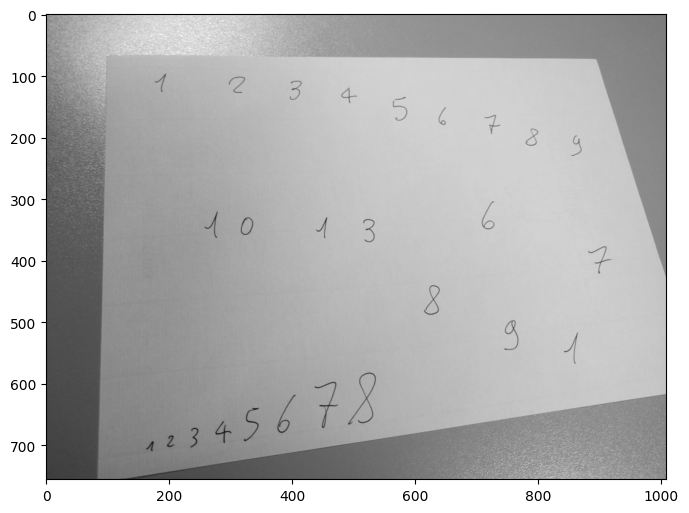

In [90]:
img = images['IMG_20190325_190049.jpg'].load_grayscale()
img = skimage.transform.rescale(img, 0.250)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
ax.imshow(img, cmap='gray')

### Adjust contrast  
For better black & white values

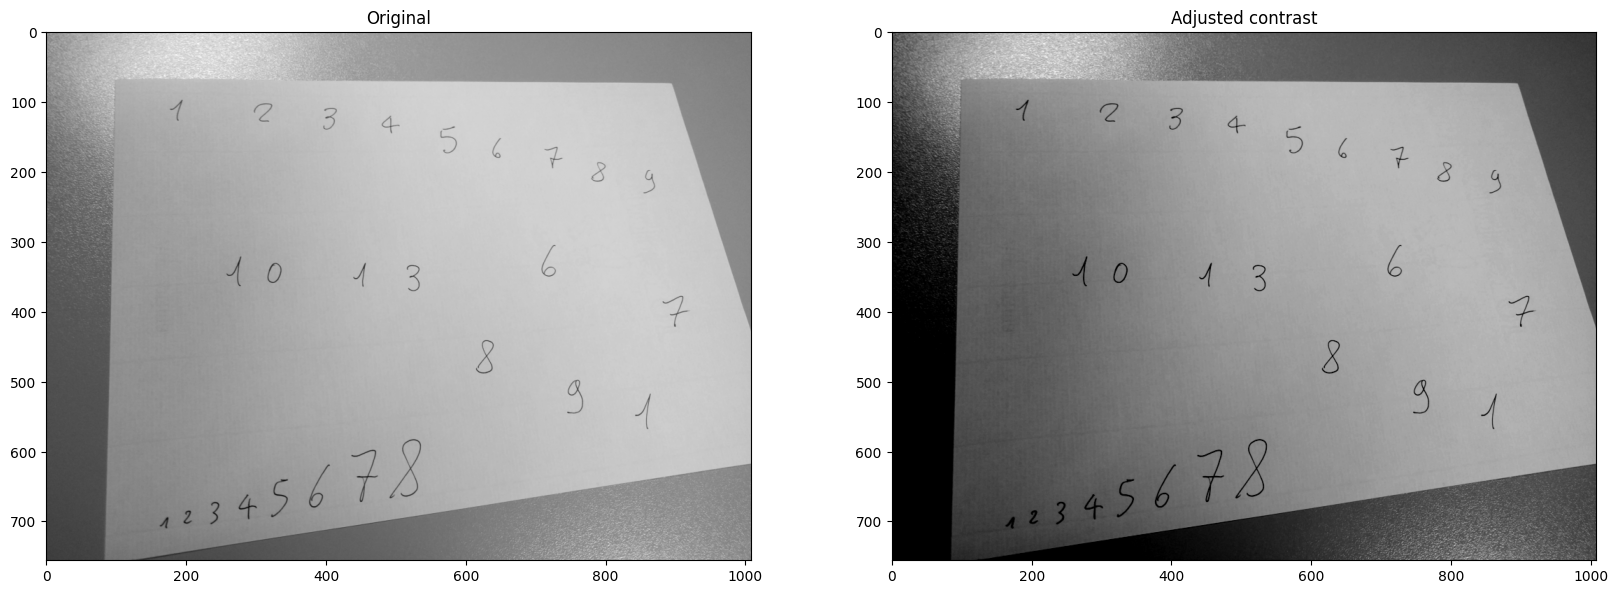

In [97]:
p2, p98 = np.percentile(img, (5, 100))
img_adjusted = skimage.exposure.rescale_intensity(img, in_range=(p2, p98))

fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(20, 9))
ax0.set_title("Original")
ax0.imshow(img, cmap='gray')
ax1.set_title("Adjusted contrast")
ax1.imshow(img_adjusted, cmap='gray')

### Edges

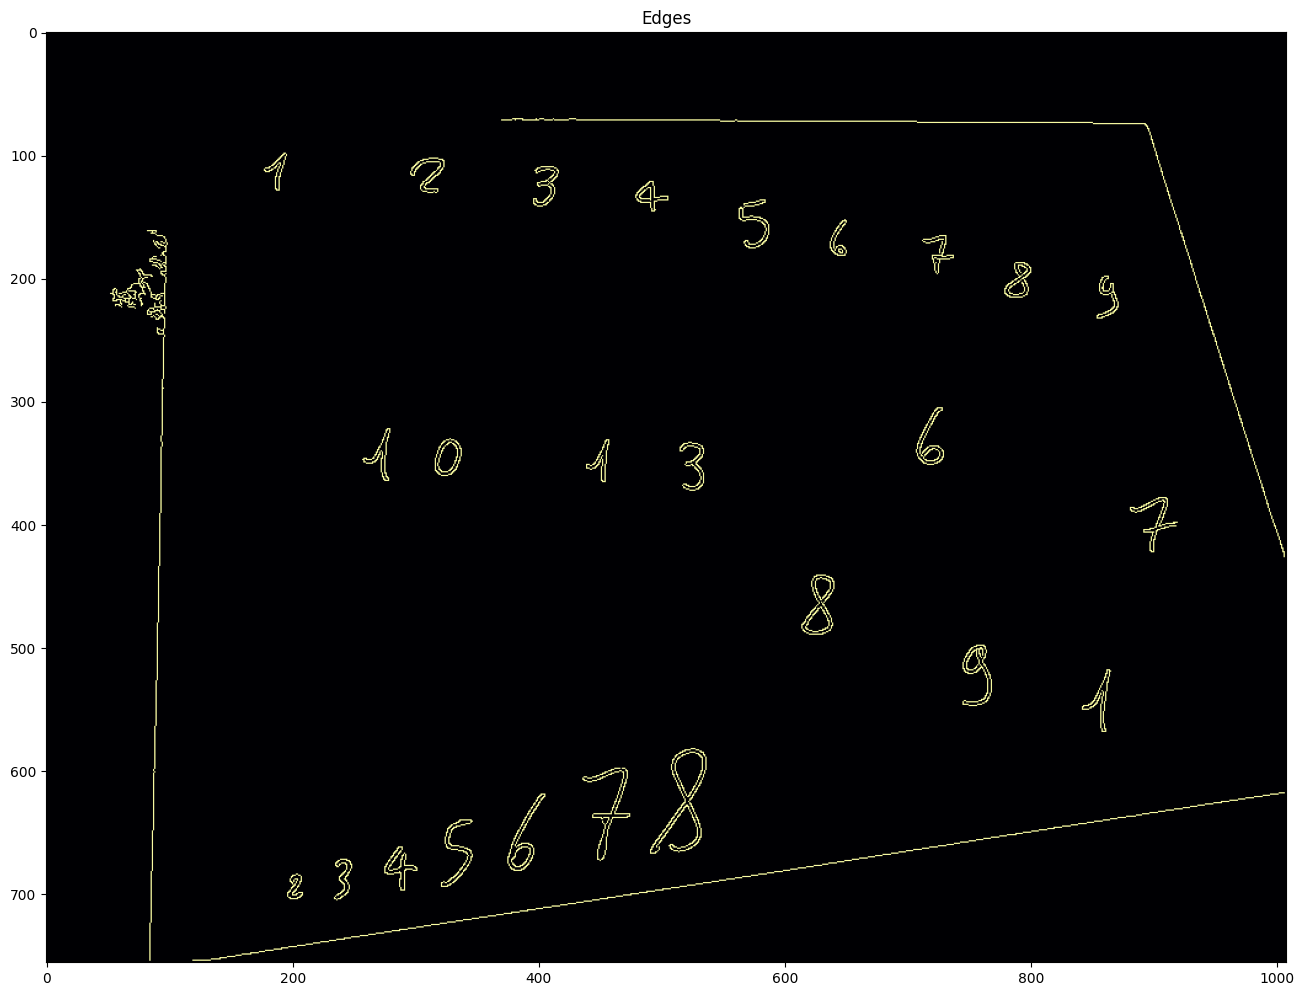

In [100]:
# Adjust contrast for better black & white values
im_edges = skimage.feature.canny(img_adjusted, low_threshold=0.1, high_threshold=0.7, sigma=1.0)
fig, ax0 = plt.subplots(nrows=1, ncols=1, figsize=(16, 16))
ax0.set_title("Edges")
ax0.imshow(im_edges, cmap='inferno')

### Detect borders of the paper

In [101]:
@widgets.interact(filter_threshold=widgets.IntSlider(value=90, min=0, max=1000.0, step=1),
                  filter_min_line_length_px=widgets.IntSlider(value=150, min=0, max=1000, step=1),
                  filter_min_line_gap_px=widgets.IntSlider(value=30, min=0, max=200, step=1))
def f(filter_threshold, filter_min_line_length_px, filter_min_line_gap_px):
    lines: list[tuple] = skimage.transform.probabilistic_hough_line(im_edges, threshold=filter_threshold, line_length=filter_min_line_length_px, line_gap=filter_min_line_gap_px)
    print(len(lines))
    fig,ax = plt.subplots(figsize=(10,10))
    ax.imshow(im_edges,cmap="gray")    
    for ((x0,y0),(x1,y1)) in lines:
        ax.plot([x0,x1],[y0,y1],'r-')
        
    plt.show() 



interactive(children=(IntSlider(value=90, description='filter_threshold', max=1000), IntSlider(value=150, desc…

6
Goups of lines: 6


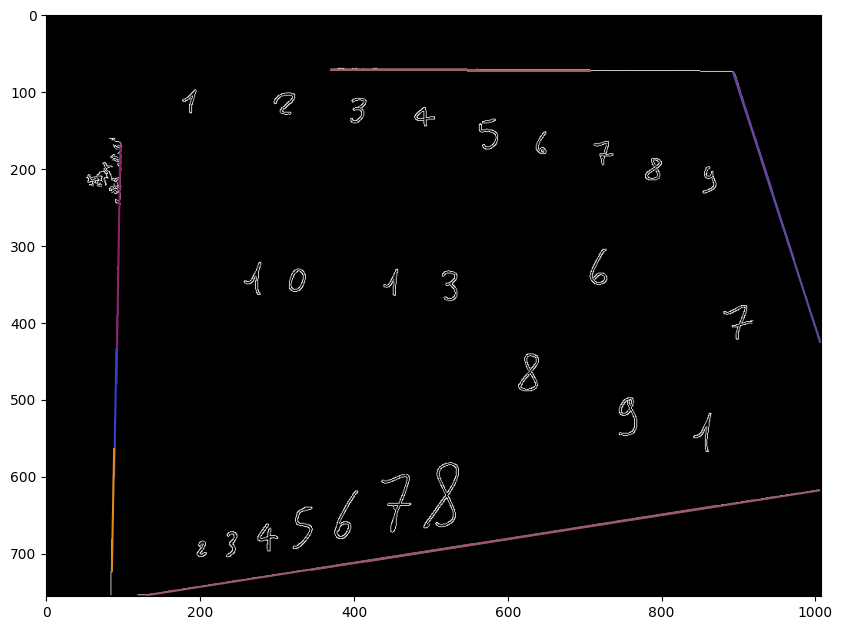

In [103]:
import math
import random
import itertools

class LineItem:
    def __init__(self, line: tuple[tuple[int]]):
        self.p1: tuple[int] = line[0]
        self.p2: tuple[int] = line[1]
        self.length: np.float64 = self.__calc_euclidean_distance(line)
        self.slope: float = self.__calc_slope(line)
        self.y_intercept: float = self.__calc_y_intercept(self.p1, self.slope)
        
    def __str__(self):
        return f'P1: {self.p1}, P2: {self.p2}, Length: {self.length}, Slope: {self.slope}, Y-Intercept: {self.y_intercept}'

    @staticmethod
    def __calc_y_intercept(point: tuple[int], slope: float) -> float:
        return point[1] - slope * point[0]

    @staticmethod
    def __calc_euclidean_distance(line: tuple[tuple[int]]):
        return np.linalg.norm(np.array(line[0]) - np.array(line[1]))

    @staticmethod
    def __calc_slope(line: tuple[tuple[int]]):
        if (line[1][0] - line[0][0]) == 0:
            return math.pi/2
        else:
            return (line[1][1] - line[0][1]) / (line[1][0] - line[0][0])

def group_lines(lines: list[LineItem]):
    # Group per slope
    groupsize_in_deg: float = 15.0
    groupsize_in_rad: float = math.pi / 180 * groupsize_in_deg
    y_intercept_dist: int = 200
    
    lines = sorted(lines, key=lambda line: (line.slope))
    
    # Group per slope
    slope_groups: list = []
    idx_reference: int = 0
    for idx, line in enumerate(lines):
        if lines[idx_reference].slope + groupsize_in_rad < line.slope:
            slope_groups.append(lines[idx_reference:idx])
            idx_reference = idx
            continue

    slope_groups.append(lines[idx_reference:])
    # print("\n".join(str(line) for line in list(itertools.chain.from_iterable(slope_groups))))
    # Group per y-intercept
    y_intercept_groups: list = []
    for group in slope_groups:
        idx_reference: int = 0
        sorted_lines = sorted(group, key=lambda line: (line.y_intercept))
        for idx, line in enumerate(sorted_lines):
            # print(f'{len(sorted_lines)}, idx:{idx}, idx_reference: {idx_reference}')
            if sorted_lines[idx_reference].y_intercept + y_intercept_dist < line.y_intercept:
                y_intercept_groups.append(sorted_lines[idx_reference:idx])
                idx_reference = idx
                continue
        
        y_intercept_groups.append(sorted_lines[idx_reference:])
        #idx_reference: int = 0

    print(len(y_intercept_groups))
    return y_intercept_groups

    
lines: list[LineItem] = [LineItem(line) for line in skimage.transform.probabilistic_hough_line(im_edges, threshold=90, line_length=150, line_gap=30)]
grouped_lines = group_lines(lines)
# print("\n".join(str(line) for line in list(itertools.chain.from_iterable(grouped_lines))))





print(f'Goups of lines: {len(grouped_lines)}')
fig,ax = plt.subplots(figsize=(10,10))
ax.imshow(im_edges,cmap="gray")
for lines in grouped_lines:
    random_value: float = random.random()
    random_color = (random_value, random.random(), 1.0 - random_value)
    for line in lines:
        ax.plot([line.p1[0], line.p2[0]], [line.p1[1], line.p2[1]], color = random_color)
        
plt.show()

## With Default Hough Lines

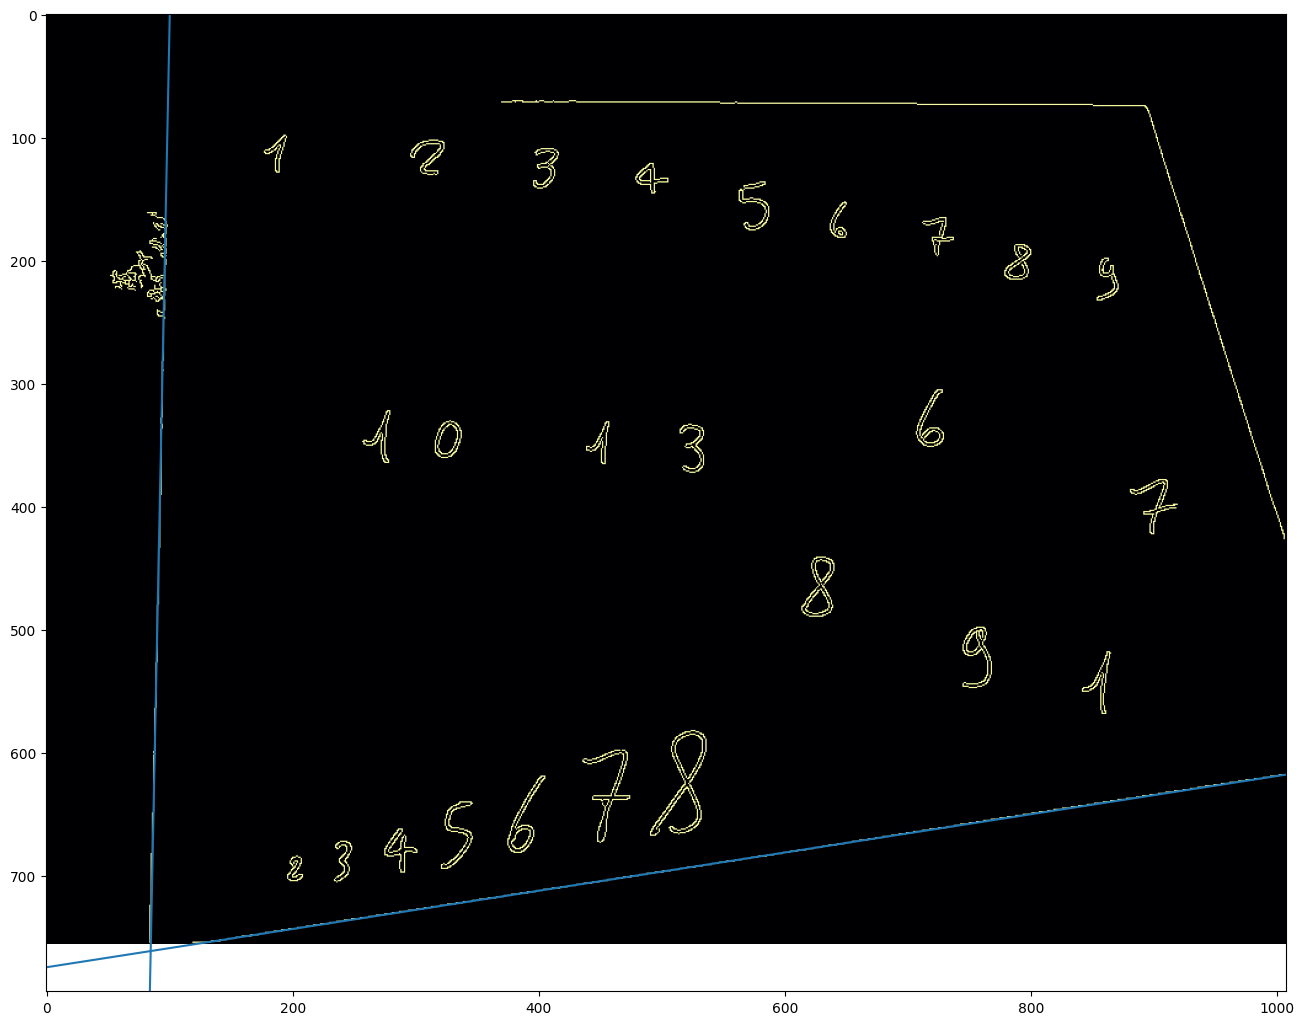

In [104]:
tested_angles = np.linspace(start=-np.pi / 2, stop=np.pi / 2, num=1080, endpoint=False)
h, theta, d = skimage.transform.hough_line(im_edges, theta=tested_angles)

hough_line_peaks = skimage.transform.hough_line_peaks(hspace=h, angles=theta, dists=d)

fig, ax0 = plt.subplots(nrows=1, ncols=1, figsize=(16, 16))
ax0.imshow(im_edges, cmap='inferno')
for acum, angle, dist in zip(*skimage.transform.hough_line_peaks(hspace=h, angles=theta, dists=d)):
    (x0, y0) = dist * np.array([np.cos(angle), np.sin(angle)])
    ax0.axline((x0, y0), slope=np.tan(angle + np.pi / 2))

### Detect crossing points

#### Helper functions

In [126]:
def extract_lines_as_homogenous_coords(hough_line_peaks):
    result: list = []
    for acum, angle, dist in zip(*hough_line_peaks):
        x0 = dist * np.cos(angle)
        y0 = dist * np.sin(angle)
        x1 = x0 + 1
        y1 = y0 + np.tan(angle + np.pi / 2)

        result.append(np.cross(np.array([x0, y0, 1]), np.array([x1, y1, 1])))
    
    return result

def extract_all_intersections(h_lines) -> list[tuple]:
    all_combinations = list(itertools.combinations(h_lines, 2))
    intersections_in_h_cords = [np.cross(pair[0], pair[1]) for pair in all_combinations]
    
    return [(point[0]/point[2], point[1]/point[2]) for point in intersections_in_h_cords]

def extract_intersections_inside_image(all_intersections: list[tuple], img_height: int, img_width: int, offset: int = 10):
    return [point for point in all_intersections if 0 - offset <= point[0] <= img_width + offset and 0 - offset <= point[1] <= img_height + offset]

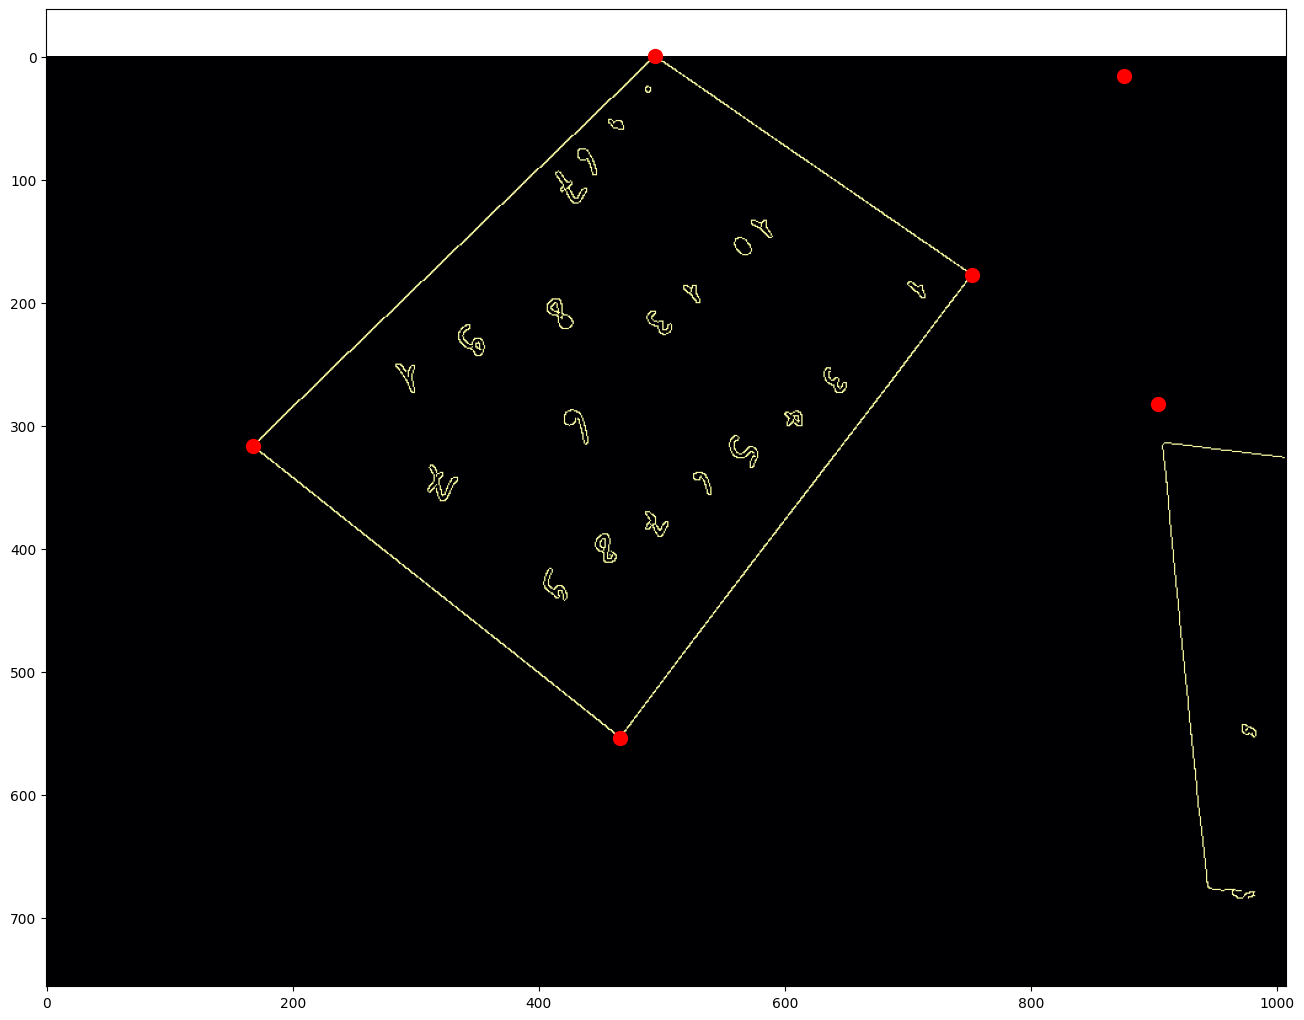

In [127]:
h_lines: list = extract_lines_as_homogenous_coords(hough_line_peaks)
all_intersections: list[tuple] = extract_all_intersections(h_lines)
all_intersections_inside_image: list[tuple] = extract_intersections_inside_image(all_intersections, im_edges.shape[0], im_edges.shape[1], 200)

fig, ax0 = plt.subplots(nrows=1, ncols=1, figsize=(16, 16))
ax0.imshow(im_edges, cmap='inferno')

for idx, intersection in enumerate(all_intersections_inside_image):
   ax0.plot(intersection[0], intersection[1], "r.", markersize=20.0)